In [1]:
# Добавляем нужные библиотеки
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.metrics import f1_score, roc_auc_score,ndcg_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


2024-04-03 17:24:14.313502: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 17:24:14.315174: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 17:24:14.338277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 17:24:14.338304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 17:24:14.339144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# загружаем таблицы данных
members_pd = pd.read_csv("members.csv")
songs_pd = pd.read_csv('songs.csv')
sample_pd = pd.read_csv("sample_submission.csv")
tranin_data_pd = pd.read_csv('train.csv')

In [3]:
#Соеденяем все таблицы в одну
merge_df = pd.merge(tranin_data_pd, members_pd, on="msno", how='inner')
train_df = pd.merge(merge_df, songs_pd, on="song_id", how='inner')

In [4]:
# Разбиваем датасет на фичи и таргетные значения
Y_data = train_df["target"]
X_data = train_df.drop(columns="target",axis= 1)
X_data.fillna("0", inplace=True)
# выделяем числовые данные и категориальные данные
numeric_features = ['city', 'bd', 'registered_via', "expiration_date", 'song_length','language']  
categorical_features = ['msno', 'song_id','source_system_tab', 'source_screen_name','source_type','gender', 'artist_name',  'composer', 'genre_ids','lyricist'] 

X_processed = X_data.copy()

# Применяем Label Encoding к каждому категориальному признаку, чтоб перевести его в числовой
# Автоматически алгоритмы из sklearn с этим не справляются
label_encoder = LabelEncoder()
for feature in categorical_features:
    X_processed[feature] = label_encoder.fit_transform(X_data[feature])

/tmp/ipykernel_59903/2184497842.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X_data.fillna("0", inplace=True)


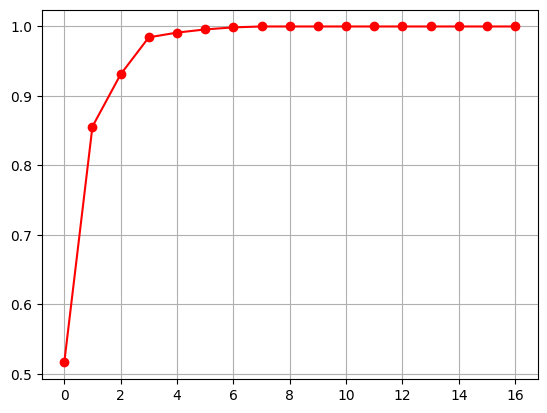

In [5]:
# Теперь, когда мы привели все данные к числовым значениям, можем воспользоваться методом главных компонент
# Это позволит снизить размерность обучающей выборки, и ускорить обучение
X_data = np.array(X_processed)
Y_data = np.array(Y_data)
pca = PCA()
x_pca = pca.fit_transform(X_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.grid()
plt.show()

In [6]:
pca_new = PCA(n_components=4)
x_new = pca_new.fit_transform(X_data)
x_train, x_test, y_train, y_test = train_test_split(x_new, Y_data, train_size=0.7)

In [7]:
# Попробуем использовать Градиентный бустинг. Он довольно хорошо справляется с данными, в которых много пробелов
# Так же он подходит для бинарной классификации, что в целом можно сказать про все алгоритмы ниже
clf = sklearn.ensemble.HistGradientBoostingClassifier(max_depth = 32,l2_regularization = 0.0)
clf.fit(x_train, y_train)

HistGradientBoostingClassifier(max_depth=32)

In [8]:
y_pred = clf.predict(x_test)
indices = np.argsort(y_pred)[::-1]
y_true_sorted = y_test[indices]
ndcg = sklearn.metrics.ndcg_score([y_true_sorted], [y_test], k= 20)
print("NDCG@k -score:", ndcg)


NDCG@k -score: 0.5617298776928702


In [ ]:
# Попробуем так же метод опорных векторов, ему по идее тоже не особо критичны пробелы в данных, так как вектора с пробелами просто не будут опорными
sv_machine = SVC(kernel='linear').fit(x_train,y_train)

In [ ]:
y_pred = sv_machine.predict(x_test)
ndcg = sklearn.metrics.ndcg_score(y_true_sorted, y_test, k= 20)
print("NDCG@k -score:", ndcg)


In [9]:
#Попробуем еще радномный лес. Он тоже должен хорошо рабоать с пробелами в данных.
rf = sklearn.ensemble.RandomForestClassifier(max_depth=32, random_state=0)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=32, random_state=0)

In [10]:
y_pred = np.array(rf.predict(x_test), dtype=bool)
indices = np.argsort(y_pred)[::-1]
y_true_sorted = y_test[indices]
ndcg = sklearn.metrics.ndcg_score([y_true_sorted], [y_test], k= 20)
print("NDCG@k -score:", ndcg)


NDCG@k -score: 0.5616144809494735
